# JSTNN
## ~~Just Stupid Trivial Neural Network~~
## Joint Structure Thermalized Neural Network

Import necessary packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Data

Define core features of the dataset

In [2]:
dim = 2
numpart = 25
box_size = 10
latent_dim = 5

Import and reshape data

In [3]:
fname = r'\\wsl$\Ubuntu\home\alepitte\ale\uni\variational-autoencoders\mc-sampling\dump\test_25_10_1_0.75_0.2_1_10000_5_x.txt'
#fname="mc-sampling/good-runs/nonpolimero_x.txt"

with open(fname) as f:
    data = [
        [float(i.strip()) for i in s.split(" ") if i != ""]
        for s in f.read().split("\n")
        if s != ""]

In [4]:
print(data[1])
data = data[200:]

[4.382034, 0.109129, 6.983773, 4.608329, 7.393892, 6.547777, 9.989857, 8.258046, 5.835079, 9.944565, 3.245596, 6.413977, 9.635955, 6.877772, 3.314133, 2.99938, 0.799742, 5.338987, 9.583705, 0.529674, 3.684495, 7.356977, 3.700608, 4.948118, 8.106619, 7.216727, 6.450932, 5.895637, 8.971798, 8.642166, 4.031466, 8.986429, 2.310979, 7.956417, 4.943601, 3.900867, 1.09093, 6.421496, 5.566295, 2.883669, 4.819179, 6.462524, 0.1095, 6.988245, 0.086978, 1.285458, 5.157357, 9.624768, 2.493443, 4.219148]


In [5]:
vcs = np.array(data).reshape((-1,numpart,dim))/box_size
print(vcs.shape)

(1800, 25, 2)


In [6]:
train_perc=0.8
trainset = vcs[:int(train_perc*len(data))]
print(trainset.shape)
test_perc=0.25*train_perc
testset = vcs[int(train_perc*len(data)):int((test_perc+train_perc)*len(data))]
print(testset.shape)

(1440, 25, 2)
(360, 25, 2)


In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
#encoder
input_shape = (numpart,dim)
inputs = layers.Input(shape=input_shape)
x = layers.Flatten()(inputs)
x = layers.Dense(int(numpart*dim*3), activation='relu')(x)#,activity_regularizer=regularizers.l1(10e-2))(x)
x = layers.Dense(int(numpart*dim*2), activation='relu')(x)#,activity_regularizer=regularizers.l1(10e-2))(x)
x = layers.Dense(int(numpart*dim*1), activation='relu')(x)#,activity_regularizer=regularizers.l1(10e-2))(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(int(numpart*dim*1), activation="relu")(latent_inputs)
x = layers.Dense(int(numpart*dim*2), activation="relu")(x)
x = layers.Dense(int(numpart*dim*3), activation="relu")(x)
x = layers.Dense(numpart*dim, activation="relu")(x)
decoder_outputs = layers.Reshape((numpart, dim))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 2)]      0           []                               
                                                                                                  
 flatten (Flatten)              (None, 50)           0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 150)          7650        ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          15100       ['dense[0][0]']                  
                                                                                            

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [10]:
#training
reg_lambda=0.001
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
fit=vae.fit(trainset, epochs=2000, batch_size=128, verbose=2)

Epoch 1/2000
12/12 - 3s - loss: 0.1148 - reconstruction_loss: 0.1145 - kl_loss: 0.2309 - 3s/epoch - 289ms/step
Epoch 2/2000
12/12 - 0s - loss: 0.0502 - reconstruction_loss: 0.0496 - kl_loss: 0.6013 - 81ms/epoch - 7ms/step
Epoch 3/2000
12/12 - 0s - loss: 0.0376 - reconstruction_loss: 0.0367 - kl_loss: 0.8805 - 79ms/epoch - 7ms/step
Epoch 4/2000
12/12 - 0s - loss: 0.0335 - reconstruction_loss: 0.0320 - kl_loss: 1.4289 - 80ms/epoch - 7ms/step
Epoch 5/2000
12/12 - 0s - loss: 0.0325 - reconstruction_loss: 0.0308 - kl_loss: 1.7150 - 77ms/epoch - 6ms/step
Epoch 6/2000
12/12 - 0s - loss: 0.0318 - reconstruction_loss: 0.0302 - kl_loss: 1.6670 - 71ms/epoch - 6ms/step
Epoch 7/2000
12/12 - 0s - loss: 0.0314 - reconstruction_loss: 0.0299 - kl_loss: 1.4952 - 79ms/epoch - 7ms/step
Epoch 8/2000
12/12 - 0s - loss: 0.0314 - reconstruction_loss: 0.0301 - kl_loss: 1.3565 - 65ms/epoch - 5ms/step
Epoch 9/2000
12/12 - 0s - loss: 0.0313 - reconstruction_loss: 0.0300 - kl_loss: 1.2616 - 81ms/epoch - 7ms/step
E

Epoch 75/2000
12/12 - 0s - loss: 0.0109 - reconstruction_loss: 0.0098 - kl_loss: 1.1434 - 94ms/epoch - 8ms/step
Epoch 76/2000
12/12 - 0s - loss: 0.0111 - reconstruction_loss: 0.0099 - kl_loss: 1.1370 - 86ms/epoch - 7ms/step
Epoch 77/2000
12/12 - 0s - loss: 0.0109 - reconstruction_loss: 0.0098 - kl_loss: 1.1320 - 79ms/epoch - 7ms/step
Epoch 78/2000
12/12 - 0s - loss: 0.0110 - reconstruction_loss: 0.0098 - kl_loss: 1.1354 - 85ms/epoch - 7ms/step
Epoch 79/2000
12/12 - 0s - loss: 0.0109 - reconstruction_loss: 0.0097 - kl_loss: 1.1314 - 78ms/epoch - 7ms/step
Epoch 80/2000
12/12 - 0s - loss: 0.0109 - reconstruction_loss: 0.0098 - kl_loss: 1.1320 - 79ms/epoch - 7ms/step
Epoch 81/2000
12/12 - 0s - loss: 0.0109 - reconstruction_loss: 0.0097 - kl_loss: 1.1368 - 63ms/epoch - 5ms/step
Epoch 82/2000
12/12 - 0s - loss: 0.0109 - reconstruction_loss: 0.0098 - kl_loss: 1.1320 - 63ms/epoch - 5ms/step
Epoch 83/2000
12/12 - 0s - loss: 0.0108 - reconstruction_loss: 0.0097 - kl_loss: 1.1264 - 66ms/epoch - 6

Epoch 148/2000
12/12 - 0s - loss: 0.0049 - reconstruction_loss: 0.0039 - kl_loss: 1.0114 - 68ms/epoch - 6ms/step
Epoch 149/2000
12/12 - 0s - loss: 0.0047 - reconstruction_loss: 0.0037 - kl_loss: 0.9766 - 79ms/epoch - 7ms/step
Epoch 150/2000
12/12 - 0s - loss: 0.0047 - reconstruction_loss: 0.0037 - kl_loss: 0.9883 - 81ms/epoch - 7ms/step
Epoch 151/2000
12/12 - 0s - loss: 0.0047 - reconstruction_loss: 0.0037 - kl_loss: 1.0129 - 78ms/epoch - 6ms/step
Epoch 152/2000
12/12 - 0s - loss: 0.0047 - reconstruction_loss: 0.0037 - kl_loss: 1.0113 - 87ms/epoch - 7ms/step
Epoch 153/2000
12/12 - 0s - loss: 0.0047 - reconstruction_loss: 0.0036 - kl_loss: 1.0088 - 93ms/epoch - 8ms/step
Epoch 154/2000
12/12 - 0s - loss: 0.0047 - reconstruction_loss: 0.0037 - kl_loss: 1.0035 - 83ms/epoch - 7ms/step
Epoch 155/2000
12/12 - 0s - loss: 0.0047 - reconstruction_loss: 0.0037 - kl_loss: 0.9951 - 77ms/epoch - 6ms/step
Epoch 156/2000
12/12 - 0s - loss: 0.0047 - reconstruction_loss: 0.0037 - kl_loss: 0.9912 - 79ms/

Epoch 221/2000
12/12 - 0s - loss: 0.0043 - reconstruction_loss: 0.0034 - kl_loss: 0.9393 - 83ms/epoch - 7ms/step
Epoch 222/2000
12/12 - 0s - loss: 0.0044 - reconstruction_loss: 0.0034 - kl_loss: 0.9335 - 79ms/epoch - 7ms/step
Epoch 223/2000
12/12 - 0s - loss: 0.0044 - reconstruction_loss: 0.0034 - kl_loss: 0.9426 - 82ms/epoch - 7ms/step
Epoch 224/2000
12/12 - 0s - loss: 0.0043 - reconstruction_loss: 0.0034 - kl_loss: 0.9350 - 66ms/epoch - 6ms/step
Epoch 225/2000
12/12 - 0s - loss: 0.0044 - reconstruction_loss: 0.0034 - kl_loss: 0.9375 - 65ms/epoch - 5ms/step
Epoch 226/2000
12/12 - 0s - loss: 0.0043 - reconstruction_loss: 0.0034 - kl_loss: 0.9445 - 67ms/epoch - 6ms/step
Epoch 227/2000
12/12 - 0s - loss: 0.0043 - reconstruction_loss: 0.0034 - kl_loss: 0.9256 - 64ms/epoch - 5ms/step
Epoch 228/2000
12/12 - 0s - loss: 0.0043 - reconstruction_loss: 0.0034 - kl_loss: 0.9268 - 62ms/epoch - 5ms/step
Epoch 229/2000
12/12 - 0s - loss: 0.0043 - reconstruction_loss: 0.0034 - kl_loss: 0.9246 - 76ms/

Epoch 294/2000
12/12 - 0s - loss: 0.0042 - reconstruction_loss: 0.0033 - kl_loss: 0.9190 - 79ms/epoch - 7ms/step
Epoch 295/2000
12/12 - 0s - loss: 0.0042 - reconstruction_loss: 0.0033 - kl_loss: 0.9054 - 80ms/epoch - 7ms/step
Epoch 296/2000
12/12 - 0s - loss: 0.0041 - reconstruction_loss: 0.0032 - kl_loss: 0.9087 - 88ms/epoch - 7ms/step
Epoch 297/2000
12/12 - 0s - loss: 0.0041 - reconstruction_loss: 0.0032 - kl_loss: 0.9029 - 78ms/epoch - 7ms/step
Epoch 298/2000
12/12 - 0s - loss: 0.0041 - reconstruction_loss: 0.0032 - kl_loss: 0.9011 - 86ms/epoch - 7ms/step
Epoch 299/2000
12/12 - 0s - loss: 0.0042 - reconstruction_loss: 0.0033 - kl_loss: 0.8937 - 81ms/epoch - 7ms/step
Epoch 300/2000
12/12 - 0s - loss: 0.0042 - reconstruction_loss: 0.0033 - kl_loss: 0.9053 - 73ms/epoch - 6ms/step
Epoch 301/2000
12/12 - 0s - loss: 0.0041 - reconstruction_loss: 0.0032 - kl_loss: 0.9106 - 78ms/epoch - 7ms/step
Epoch 302/2000
12/12 - 0s - loss: 0.0041 - reconstruction_loss: 0.0032 - kl_loss: 0.8934 - 66ms/

Epoch 367/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0031 - kl_loss: 0.9100 - 74ms/epoch - 6ms/step
Epoch 368/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0031 - kl_loss: 0.9069 - 78ms/epoch - 7ms/step
Epoch 369/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0031 - kl_loss: 0.8960 - 77ms/epoch - 6ms/step
Epoch 370/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0031 - kl_loss: 0.9014 - 79ms/epoch - 7ms/step
Epoch 371/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0031 - kl_loss: 0.8954 - 72ms/epoch - 6ms/step
Epoch 372/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0031 - kl_loss: 0.8968 - 79ms/epoch - 7ms/step
Epoch 373/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0031 - kl_loss: 0.8962 - 87ms/epoch - 7ms/step
Epoch 374/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0031 - kl_loss: 0.8817 - 84ms/epoch - 7ms/step
Epoch 375/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0031 - kl_loss: 0.8909 - 78ms/

Epoch 440/2000
12/12 - 0s - loss: 0.0039 - reconstruction_loss: 0.0030 - kl_loss: 0.8963 - 79ms/epoch - 7ms/step
Epoch 441/2000
12/12 - 0s - loss: 0.0039 - reconstruction_loss: 0.0030 - kl_loss: 0.8928 - 79ms/epoch - 7ms/step
Epoch 442/2000
12/12 - 0s - loss: 0.0039 - reconstruction_loss: 0.0030 - kl_loss: 0.9235 - 79ms/epoch - 7ms/step
Epoch 443/2000
12/12 - 0s - loss: 0.0039 - reconstruction_loss: 0.0030 - kl_loss: 0.8769 - 66ms/epoch - 6ms/step
Epoch 444/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0030 - kl_loss: 0.9112 - 75ms/epoch - 6ms/step
Epoch 445/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0031 - kl_loss: 0.8843 - 80ms/epoch - 7ms/step
Epoch 446/2000
12/12 - 0s - loss: 0.0039 - reconstruction_loss: 0.0030 - kl_loss: 0.9032 - 81ms/epoch - 7ms/step
Epoch 447/2000
12/12 - 0s - loss: 0.0040 - reconstruction_loss: 0.0031 - kl_loss: 0.8997 - 76ms/epoch - 6ms/step
Epoch 448/2000
12/12 - 0s - loss: 0.0039 - reconstruction_loss: 0.0030 - kl_loss: 0.8907 - 73ms/

Epoch 513/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0029 - kl_loss: 0.8897 - 83ms/epoch - 7ms/step
Epoch 514/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0029 - kl_loss: 0.8750 - 74ms/epoch - 6ms/step
Epoch 515/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0029 - kl_loss: 0.8910 - 102ms/epoch - 9ms/step
Epoch 516/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0029 - kl_loss: 0.8990 - 66ms/epoch - 6ms/step
Epoch 517/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0029 - kl_loss: 0.8904 - 79ms/epoch - 7ms/step
Epoch 518/2000
12/12 - 0s - loss: 0.0039 - reconstruction_loss: 0.0029 - kl_loss: 0.9589 - 79ms/epoch - 7ms/step
Epoch 519/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0029 - kl_loss: 0.9059 - 97ms/epoch - 8ms/step
Epoch 520/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0029 - kl_loss: 0.8908 - 87ms/epoch - 7ms/step
Epoch 521/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0029 - kl_loss: 0.9115 - 84ms

Epoch 586/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8976 - 79ms/epoch - 7ms/step
Epoch 587/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9022 - 79ms/epoch - 7ms/step
Epoch 588/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0029 - kl_loss: 0.8941 - 71ms/epoch - 6ms/step
Epoch 589/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0029 - kl_loss: 0.8838 - 82ms/epoch - 7ms/step
Epoch 590/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0028 - kl_loss: 0.9110 - 79ms/epoch - 7ms/step
Epoch 591/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9002 - 67ms/epoch - 6ms/step
Epoch 592/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8976 - 65ms/epoch - 5ms/step
Epoch 593/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8979 - 86ms/epoch - 7ms/step
Epoch 594/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9061 - 78ms/

Epoch 659/2000
12/12 - 0s - loss: 0.0038 - reconstruction_loss: 0.0028 - kl_loss: 0.9318 - 78ms/epoch - 6ms/step
Epoch 660/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9220 - 80ms/epoch - 7ms/step
Epoch 661/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8912 - 84ms/epoch - 7ms/step
Epoch 662/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9261 - 81ms/epoch - 7ms/step
Epoch 663/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8921 - 79ms/epoch - 7ms/step
Epoch 664/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8789 - 82ms/epoch - 7ms/step
Epoch 665/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9001 - 82ms/epoch - 7ms/step
Epoch 666/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9118 - 68ms/epoch - 6ms/step
Epoch 667/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8906 - 76ms/

Epoch 732/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8965 - 82ms/epoch - 7ms/step
Epoch 733/2000
12/12 - 0s - loss: 0.0036 - reconstruction_loss: 0.0027 - kl_loss: 0.8993 - 79ms/epoch - 7ms/step
Epoch 734/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0027 - kl_loss: 0.9177 - 77ms/epoch - 6ms/step
Epoch 735/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9124 - 81ms/epoch - 7ms/step
Epoch 736/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9189 - 61ms/epoch - 5ms/step
Epoch 737/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0027 - kl_loss: 0.9054 - 80ms/epoch - 7ms/step
Epoch 738/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9048 - 85ms/epoch - 7ms/step
Epoch 739/2000
12/12 - 0s - loss: 0.0036 - reconstruction_loss: 0.0027 - kl_loss: 0.8938 - 67ms/epoch - 6ms/step
Epoch 740/2000
12/12 - 0s - loss: 0.0036 - reconstruction_loss: 0.0028 - kl_loss: 0.8994 - 79ms/

Epoch 805/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9038 - 105ms/epoch - 9ms/step
Epoch 806/2000
12/12 - 0s - loss: 0.0036 - reconstruction_loss: 0.0027 - kl_loss: 0.8836 - 71ms/epoch - 6ms/step
Epoch 807/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8998 - 73ms/epoch - 6ms/step
Epoch 808/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8959 - 93ms/epoch - 8ms/step
Epoch 809/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0027 - kl_loss: 0.9250 - 111ms/epoch - 9ms/step
Epoch 810/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8900 - 93ms/epoch - 8ms/step
Epoch 811/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0027 - kl_loss: 0.9049 - 123ms/epoch - 10ms/step
Epoch 812/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.9021 - 85ms/epoch - 7ms/step
Epoch 813/2000
12/12 - 0s - loss: 0.0036 - reconstruction_loss: 0.0027 - kl_loss: 0.9000 - 7

Epoch 878/2000
12/12 - 0s - loss: 0.0036 - reconstruction_loss: 0.0027 - kl_loss: 0.8978 - 84ms/epoch - 7ms/step
Epoch 879/2000
12/12 - 0s - loss: 0.0036 - reconstruction_loss: 0.0027 - kl_loss: 0.8932 - 90ms/epoch - 7ms/step
Epoch 880/2000
12/12 - 0s - loss: 0.0036 - reconstruction_loss: 0.0027 - kl_loss: 0.9689 - 77ms/epoch - 6ms/step
Epoch 881/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8905 - 88ms/epoch - 7ms/step
Epoch 882/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0028 - kl_loss: 0.8948 - 86ms/epoch - 7ms/step
Epoch 883/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0027 - kl_loss: 0.9466 - 86ms/epoch - 7ms/step
Epoch 884/2000
12/12 - 0s - loss: 0.0036 - reconstruction_loss: 0.0027 - kl_loss: 0.8891 - 91ms/epoch - 8ms/step
Epoch 885/2000
12/12 - 0s - loss: 0.0037 - reconstruction_loss: 0.0027 - kl_loss: 0.9325 - 99ms/epoch - 8ms/step
Epoch 886/2000
12/12 - 0s - loss: 0.0036 - reconstruction_loss: 0.0027 - kl_loss: 0.9061 - 95ms/

Epoch 951/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9168 - 84ms/epoch - 7ms/step
Epoch 952/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9011 - 75ms/epoch - 6ms/step
Epoch 953/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9256 - 71ms/epoch - 6ms/step
Epoch 954/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9249 - 79ms/epoch - 7ms/step
Epoch 955/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9112 - 71ms/epoch - 6ms/step
Epoch 956/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9002 - 78ms/epoch - 7ms/step
Epoch 957/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9157 - 78ms/epoch - 7ms/step
Epoch 958/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9213 - 83ms/epoch - 7ms/step
Epoch 959/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9229 - 76ms/

12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9138 - 99ms/epoch - 8ms/step
Epoch 1024/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9097 - 100ms/epoch - 8ms/step
Epoch 1025/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9131 - 96ms/epoch - 8ms/step
Epoch 1026/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.8900 - 99ms/epoch - 8ms/step
Epoch 1027/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9207 - 102ms/epoch - 9ms/step
Epoch 1028/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9200 - 93ms/epoch - 8ms/step
Epoch 1029/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9115 - 99ms/epoch - 8ms/step
Epoch 1030/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9241 - 93ms/epoch - 8ms/step
Epoch 1031/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.8841 - 106ms/epoc

Epoch 1095/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9142 - 85ms/epoch - 7ms/step
Epoch 1096/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9152 - 78ms/epoch - 7ms/step
Epoch 1097/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9235 - 79ms/epoch - 7ms/step
Epoch 1098/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9328 - 79ms/epoch - 7ms/step
Epoch 1099/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9137 - 87ms/epoch - 7ms/step
Epoch 1100/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9296 - 71ms/epoch - 6ms/step
Epoch 1101/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9199 - 81ms/epoch - 7ms/step
Epoch 1102/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9053 - 94ms/epoch - 8ms/step
Epoch 1103/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.918

Epoch 1167/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9071 - 96ms/epoch - 8ms/step
Epoch 1168/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9116 - 87ms/epoch - 7ms/step
Epoch 1169/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9488 - 95ms/epoch - 8ms/step
Epoch 1170/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9056 - 90ms/epoch - 8ms/step
Epoch 1171/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.8960 - 97ms/epoch - 8ms/step
Epoch 1172/2000
12/12 - 0s - loss: 0.0035 - reconstruction_loss: 0.0025 - kl_loss: 1.0088 - 99ms/epoch - 8ms/step
Epoch 1173/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9111 - 96ms/epoch - 8ms/step
Epoch 1174/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9054 - 93ms/epoch - 8ms/step
Epoch 1175/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.909

Epoch 1239/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9238 - 98ms/epoch - 8ms/step
Epoch 1240/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9109 - 95ms/epoch - 8ms/step
Epoch 1241/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9480 - 81ms/epoch - 7ms/step
Epoch 1242/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9754 - 95ms/epoch - 8ms/step
Epoch 1243/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9272 - 75ms/epoch - 6ms/step
Epoch 1244/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9128 - 79ms/epoch - 7ms/step
Epoch 1245/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9108 - 83ms/epoch - 7ms/step
Epoch 1246/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9199 - 74ms/epoch - 6ms/step
Epoch 1247/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.921

Epoch 1311/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9240 - 63ms/epoch - 5ms/step
Epoch 1312/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9225 - 63ms/epoch - 5ms/step
Epoch 1313/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9135 - 77ms/epoch - 6ms/step
Epoch 1314/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9217 - 79ms/epoch - 7ms/step
Epoch 1315/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9340 - 79ms/epoch - 7ms/step
Epoch 1316/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9314 - 79ms/epoch - 7ms/step
Epoch 1317/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9259 - 79ms/epoch - 7ms/step
Epoch 1318/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9687 - 78ms/epoch - 7ms/step
Epoch 1319/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.938

Epoch 1383/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9110 - 80ms/epoch - 7ms/step
Epoch 1384/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9407 - 65ms/epoch - 5ms/step
Epoch 1385/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.8992 - 75ms/epoch - 6ms/step
Epoch 1386/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9148 - 77ms/epoch - 6ms/step
Epoch 1387/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9080 - 81ms/epoch - 7ms/step
Epoch 1388/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9227 - 79ms/epoch - 7ms/step
Epoch 1389/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9231 - 81ms/epoch - 7ms/step
Epoch 1390/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9080 - 79ms/epoch - 7ms/step
Epoch 1391/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.922

Epoch 1455/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9179 - 96ms/epoch - 8ms/step
Epoch 1456/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9259 - 74ms/epoch - 6ms/step
Epoch 1457/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9457 - 64ms/epoch - 5ms/step
Epoch 1458/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9320 - 65ms/epoch - 5ms/step
Epoch 1459/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9084 - 65ms/epoch - 5ms/step
Epoch 1460/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9114 - 75ms/epoch - 6ms/step
Epoch 1461/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9010 - 109ms/epoch - 9ms/step
Epoch 1462/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9160 - 74ms/epoch - 6ms/step
Epoch 1463/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.95

Epoch 1527/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9083 - 78ms/epoch - 7ms/step
Epoch 1528/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9227 - 81ms/epoch - 7ms/step
Epoch 1529/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9353 - 76ms/epoch - 6ms/step
Epoch 1530/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9217 - 63ms/epoch - 5ms/step
Epoch 1531/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9078 - 80ms/epoch - 7ms/step
Epoch 1532/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9194 - 79ms/epoch - 7ms/step
Epoch 1533/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9136 - 79ms/epoch - 7ms/step
Epoch 1534/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9340 - 78ms/epoch - 7ms/step
Epoch 1535/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.949

Epoch 1599/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9308 - 76ms/epoch - 6ms/step
Epoch 1600/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9419 - 65ms/epoch - 5ms/step
Epoch 1601/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9140 - 73ms/epoch - 6ms/step
Epoch 1602/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9344 - 78ms/epoch - 7ms/step
Epoch 1603/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9522 - 63ms/epoch - 5ms/step
Epoch 1604/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9409 - 79ms/epoch - 7ms/step
Epoch 1605/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.9193 - 79ms/epoch - 7ms/step
Epoch 1606/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.8957 - 81ms/epoch - 7ms/step
Epoch 1607/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.919

Epoch 1671/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9195 - 82ms/epoch - 7ms/step
Epoch 1672/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9125 - 75ms/epoch - 6ms/step
Epoch 1673/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9362 - 80ms/epoch - 7ms/step
Epoch 1674/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9291 - 67ms/epoch - 6ms/step
Epoch 1675/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9074 - 75ms/epoch - 6ms/step
Epoch 1676/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9323 - 79ms/epoch - 7ms/step
Epoch 1677/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9378 - 83ms/epoch - 7ms/step
Epoch 1678/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9234 - 81ms/epoch - 7ms/step
Epoch 1679/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.953

Epoch 1743/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9058 - 74ms/epoch - 6ms/step
Epoch 1744/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9123 - 79ms/epoch - 7ms/step
Epoch 1745/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9400 - 81ms/epoch - 7ms/step
Epoch 1746/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9390 - 83ms/epoch - 7ms/step
Epoch 1747/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9191 - 83ms/epoch - 7ms/step
Epoch 1748/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9354 - 74ms/epoch - 6ms/step
Epoch 1749/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0023 - kl_loss: 0.9718 - 64ms/epoch - 5ms/step
Epoch 1750/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9286 - 80ms/epoch - 7ms/step
Epoch 1751/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.939

Epoch 1815/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9377 - 79ms/epoch - 7ms/step
Epoch 1816/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9286 - 61ms/epoch - 5ms/step
Epoch 1817/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9614 - 64ms/epoch - 5ms/step
Epoch 1818/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9512 - 87ms/epoch - 7ms/step
Epoch 1819/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9436 - 68ms/epoch - 6ms/step
Epoch 1820/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9179 - 80ms/epoch - 7ms/step
Epoch 1821/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9181 - 83ms/epoch - 7ms/step
Epoch 1822/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9434 - 80ms/epoch - 7ms/step
Epoch 1823/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0025 - kl_loss: 0.975

Epoch 1887/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9254 - 95ms/epoch - 8ms/step
Epoch 1888/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9319 - 94ms/epoch - 8ms/step
Epoch 1889/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9371 - 79ms/epoch - 7ms/step
Epoch 1890/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9309 - 80ms/epoch - 7ms/step
Epoch 1891/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9331 - 78ms/epoch - 6ms/step
Epoch 1892/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9291 - 79ms/epoch - 7ms/step
Epoch 1893/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9150 - 73ms/epoch - 6ms/step
Epoch 1894/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9477 - 78ms/epoch - 7ms/step
Epoch 1895/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.948

Epoch 1959/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9335 - 79ms/epoch - 7ms/step
Epoch 1960/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9324 - 79ms/epoch - 7ms/step
Epoch 1961/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9714 - 79ms/epoch - 7ms/step
Epoch 1962/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9178 - 78ms/epoch - 7ms/step
Epoch 1963/2000
12/12 - 0s - loss: 0.0035 - reconstruction_loss: 0.0025 - kl_loss: 1.0074 - 72ms/epoch - 6ms/step
Epoch 1964/2000
12/12 - 0s - loss: 0.0034 - reconstruction_loss: 0.0024 - kl_loss: 0.9797 - 79ms/epoch - 7ms/step
Epoch 1965/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.8957 - 79ms/epoch - 7ms/step
Epoch 1966/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.9100 - 79ms/epoch - 7ms/step
Epoch 1967/2000
12/12 - 0s - loss: 0.0033 - reconstruction_loss: 0.0024 - kl_loss: 0.969

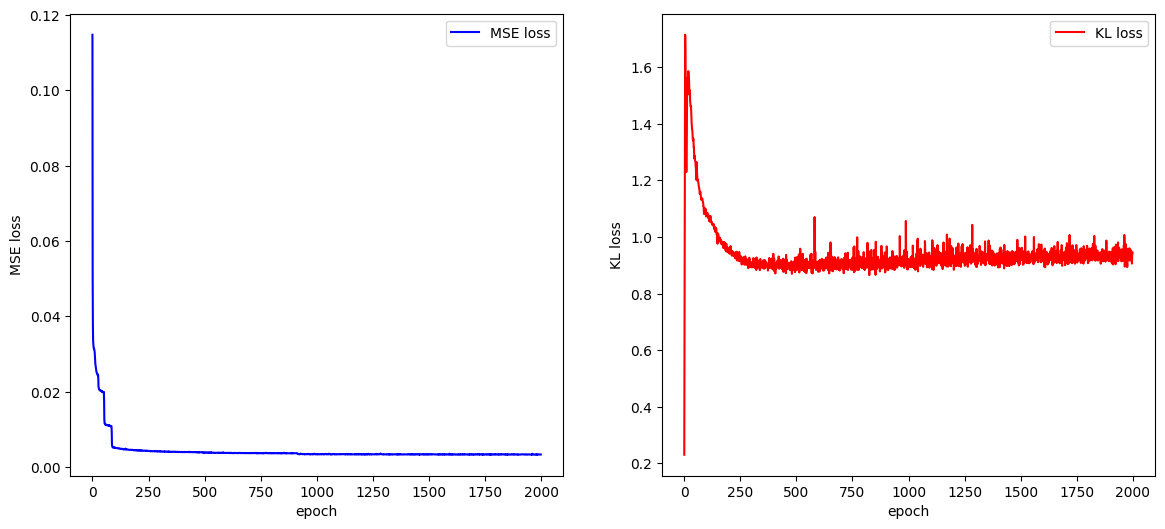

In [11]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['loss'],label="MSE loss",c="b")
ax.set_xlabel('epoch')
ax.set_ylabel("MSE loss")
ax.legend()
ax=AX[1]
ax.plot(fit.history['kl_loss'],label="KL loss",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("KL loss")
ax.legend()

## Evaluate performance
We'll now use the test set to explore the latent space distribution of data and the reconstruction accuracy

In [12]:
encoded_test = np.array(vae.encoder.predict(testset))

12/12 [==============================] - 0s 1ms/step


In [13]:
print(encoded_test.shape)

(3, 360, 5)


z_mean are the first dimension, z_log_var the second (used in training), we're interested in the third dimension, which are the sampled z

In [14]:
dim1 = encoded_test[2,:,:]
print(dim1.shape)

(360, 5)


Sampling in the latent space is reasonably gaussian as expected

In [15]:
#df = pd.DataFrame(dim1, columns=["x", "y"])
#sns.jointplot(x="x", y="y", data=df);

We can now use the data to decode

In [16]:
decoded_test = np.array(decoder.predict(encoded_test[2,:,:])).reshape(-1,numpart,dim)
print(decoded_test.shape)

12/12 [==============================] - 0s 2ms/step
(360, 25, 2)


#### Check reconstruction

In [17]:
decoded_test[2]

array([[0.9675866 , 0.34414095],
       [0.06642163, 0.02342345],
       [0.9982222 , 0.18180504],
       [0.80358434, 0.06168083],
       [0.90368485, 0.24066153],
       [0.        , 0.25283313],
       [0.33858496, 0.02883915],
       [0.536933  , 0.18529993],
       [0.46134508, 0.08884493],
       [0.7054436 , 0.01967019],
       [0.14003304, 0.11973518],
       [0.6360037 , 0.10330544],
       [0.5750983 , 0.00567615],
       [0.92849874, 0.01511764],
       [0.8177588 , 0.18393333],
       [0.7116684 , 0.18694453],
       [0.19664302, 0.01479603],
       [0.41718668, 0.24312901],
       [0.251436  , 0.        ],
       [0.6297852 , 0.2973915 ],
       [0.751906  , 0.30390155],
       [0.21452722, 0.21309453],
       [0.36801738, 0.13423094],
       [0.89633375, 0.11660524],
       [0.03149285, 0.15146586]], dtype=float32)

In [18]:
ts = testset.reshape(-1,numpart,dim)
print(ts[2,:,:])

[[0.9796418 0.3239042]
 [0.0021162 0.0714295]
 [0.997776  0.224951 ]
 [0.7903989 0.0921439]
 [0.8719565 0.282716 ]
 [0.1291034 0.2490643]
 [0.339853  0.0099114]
 [0.5673963 0.2206542]
 [0.5022063 0.1180269]
 [0.7227972 0.0136445]
 [0.1332081 0.136736 ]
 [0.6062833 0.0501741]
 [0.4755919 0.0065519]
 [0.9654014 0.0088157]
 [0.8014585 0.2073173]
 [0.6958916 0.1537806]
 [0.1113285 0.0171652]
 [0.4609177 0.2368611]
 [0.2524148 0.0911155]
 [0.5861092 0.3532242]
 [0.7170152 0.2793325]
 [0.2466085 0.2157857]
 [0.3971272 0.1129069]
 [0.8980109 0.1119215]
 [0.0218567 0.1849712]]


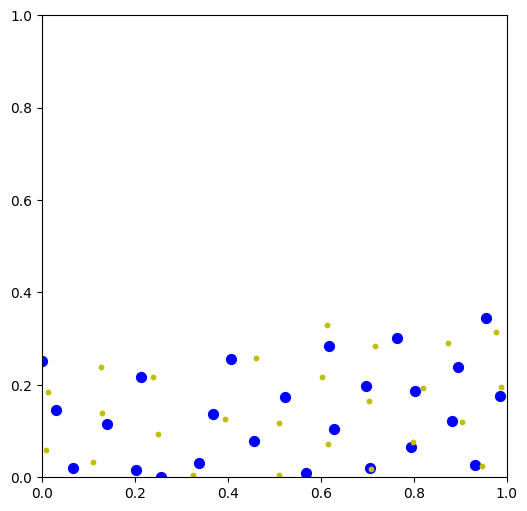

In [19]:
if dim == 2:
    ind = 1
    plt.figure(figsize=(6, 6))
    plt.scatter(decoded_test[ind,:,0], decoded_test[ind,:,1], s=50, c="b")
    plt.scatter(ts[ind,:,0], ts[ind,:,1], s=10, c="y")
    plt.xlim(0, 1)
    plt.ylim(0, 1)

MovieWriter imagemagick unavailable; using Pillow instead.


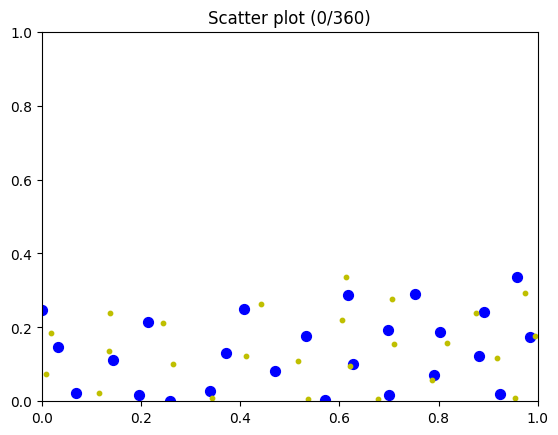

In [22]:
from matplotlib.animation import FuncAnimation

# Create the figure and axis objects
fig, ax = plt.subplots()

nframes = len(decoded_test)

# Define the animation function
def update(ind):
    ax.clear()
    plt.scatter(decoded_test[ind,:,0], decoded_test[ind,:,1], s=50, c="b")
    plt.scatter(ts[ind,:,0], ts[ind,:,1], s=10, c="y")
    ax.set_title(f"Scatter plot ({ind}/{nframes})")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

# Create the animation
animation = FuncAnimation(fig, update, frames=nframes, interval=200)

# Save the animation as a GIF
animation.save("prediction.gif", writer="imagemagick")


In [20]:
if dim ==3:
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(decoded_test[1,:,0], decoded_test[1,:,1],decoded_test[1,:,2], s=30, c="b", depthshade=True)
    ax.scatter(ts[1,:,0], ts[1,:,1],ts[1,:,2], s=30, c="y", depthshade=True)
    ax.view_init(45,45)

57/57 [==============================] - 0s 3ms/step
0.6747753579202406 0.32503119213287957 0.9998065500531201


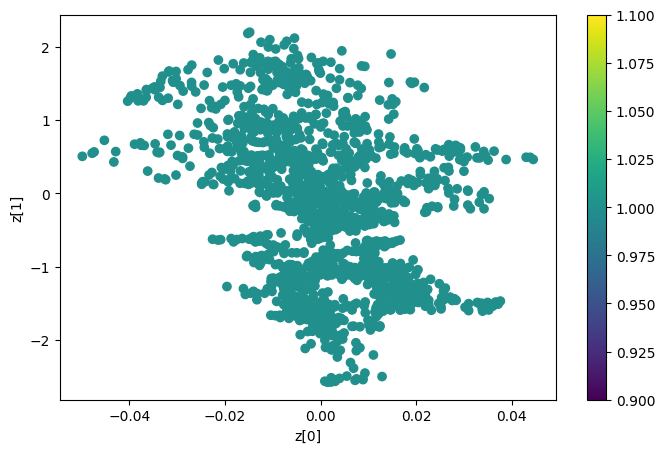

In [21]:
from scipy import linalg as la

labels = [1]*len(data)
def label_vis(vae, data, labels):
    
    #prediction
    z_mean, _, _ = vae.encoder.predict(data)
    
    #PCA on z_mean
    A = pd.DataFrame(z_mean)
    l, V = la.eig(np.cov(A.T))
    lr = np.copy(l.real)
    n1 = np.argmax(l)
    l[n1] = 0
    n2 = np.argmax(l)
    print(lr[n1]/sum(lr), lr[n2]/sum(lr), (lr[n1]+lr[n2])/sum(lr) )

    #plot
    plt.figure(figsize=(8, 5))
    plt.scatter(z_mean[:, n1], z_mean[:, n2], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

label_vis(vae, vcs, labels)